In [2]:
from model import *
from data import *

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,'dataset/datas/','allimages','allmasks',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_covid.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(myGene,steps_per_epoch=1,epochs=20,callbacks=[model_checkpoint])

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.9862
Epoch 00001: loss improved from inf to 0.58927, saving model to unet_covid.hdf5
1/1 [==============================] - 1s 775ms/step - loss: 0.5893 - accuracy: 0.9862
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.9488
Epoch 00002: loss improved from 0.58927 to 0.37163, saving model to unet_covid.hdf5
1/1 [==============================] - 1s 765ms/step - loss: 0.3716 - accuracy: 0.9488
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9741
Epoch 00003: loss improved from 0.37163 to 0.14184, saving model to unet_covid.hdf5
1/1 [==============================] - 0s 426ms/step - loss: 0.1418 - accuracy: 0.9741
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9877
Epoch 00004: loss improved from 0.14184 t

In [4]:
#model.summary()

### test your model and save predicted results

In [5]:
testGene = testGenerator("dataset/alltest/")
model = unet()
model.load_weights("unet_covid.hdf5")
results = model.predict_generator(testGene,10,verbose=1)
# saveResult("dataset/alltest",results)

Instructions for updating:
Please use Model.predict, which supports generators.
10/10 [==============================] - 16s 2s/step


In [6]:
#results.shape

In [7]:
#import matplotlib.pyplot as plt


In [8]:
#plt.imsave('predict-0.jpg',results[0,:,:,0],cmap="gray")

In [9]:
#plt.imshow(results[0,:,:,:])

In [10]:
#plt.imshow(results[1,:,:,:])

In [11]:
#results[0,:,:,:].shape

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

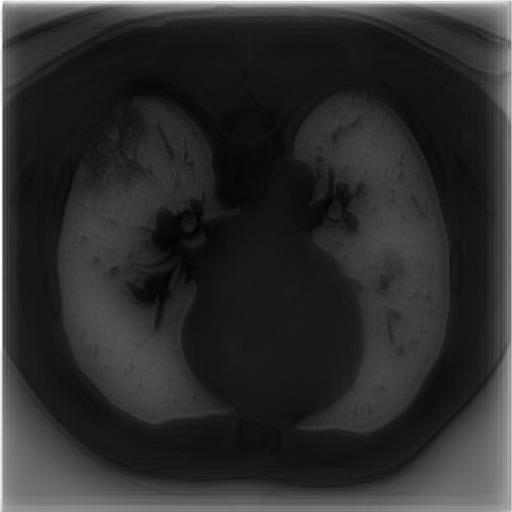

In [28]:
preprocess_input = keras.applications.xception.preprocess_input
img_size = (512, 512)
last_conv_layer_name = "conv2d_47"
img_path = ('dataset/alltest/0_predict.jpg')
display(Image(img_path))

In [29]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [30]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
#print(img_array)
#model.summary()
#print(last_conv_layer_name)
# print(model.layers)


In [31]:
#model.inputs
#model.output
#model.get_layer("conv2d_47").output

In [32]:
# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
# model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

UnimplementedError: The Conv2D op currently does not support grouped convolutions on the CPU. A grouped convolution was attempted to be run because the input depth of 3 does not match the filter input depth of 1 [Op:Conv2D]